# 实验内容
https://www.youtube.com/watch?v=CbTU92pbDKw&list=PLzYUjRAdu5V_J0wClDakA95Qwi2uSj5oX&index=3

In [106]:
import os
import pandas as pd
from rich.console import Console
from rich.theme import Theme
from rich.table import Table
console = Console()
DIR = os.path.abspath('')
df = pd.read_csv(DIR+'\\MSFT.csv')

read_diff = open(DIR+'\\diff-2022-12-21.csv', 'r', encoding='utf8')
diff = []
for line in read_diff:
    line = line.strip()
    line_ = line.split(',')
    diff.append(line_)
read_diff.close()
print()

read_date = open(DIR+'\\auto2-2022-12-21.csv', 'r', encoding='utf8')
date_ = []
for line in read_date:
    line = line.strip()
    time_, _ = line.split(',')
    date_.append(time_)
read_date.close()

diff2 = []
for i in range(len(diff)):
    # console.print(date_[i])
    # console.print(diff[i][-21:])
    temp_ = [date_[i]] + diff[i][-21:]
    diff2.append(temp_)

# console.print(diff2[20:])

header = ['time']
for i in range(20):
    header.append('col_'+str(i+1))
header.append('result')
df2 = pd.DataFrame(diff2[20:], columns=header)

df2

,time,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,result
0,2022-12-21 08:34:16,1,2,0,1,0,-1,2,-2,-2,...,1,-2,0,0,0,1,1,-1,1,2
1,2022-12-21 08:35:14,2,0,1,0,-1,2,-2,-2,1,...,-2,0,0,0,1,1,-1,1,2,0
2,2022-12-21 08:36:12,0,1,0,-1,2,-2,-2,1,0,...,0,0,0,1,1,-1,1,2,0,-1
3,2022-12-21 08:37:10,1,0,-1,2,-2,-2,1,0,1,...,0,0,1,1,-1,1,2,0,-1,-2
4,2022-12-21 08:38:08,0,-1,2,-2,-2,1,0,1,-2,...,0,1,1,-1,1,2,0,-1,-2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2022-12-21 11:28:16,-3,3,0,-3,0,3,-1,-3,3,...,0,3,0,1,0,-2,2,-3,-1,4
181,2022-12-21 11:29:14,3,0,-3,0,3,-1,-3,3,1,...,3,0,1,0,-2,2,-3,-1,4,-3
182,2022-12-21 11:30:12,0,-3,0,3,-1,-3,3,1,-4,...,0,1,0,-2,2,-3,-1,4,-3,2
183,2022-12-21 11:31:10,-3,0,3,-1,-3,3,1,-4,0,...,1,0,-2,2,-3,-1,4,-3,2,-1


In [ ]:
df = df[['Date', 'Close']]

df

In [ ]:
df['Date']

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

In [ ]:
df

In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

In [ ]:
df.index = df.pop('Date')
df

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

In [107]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(df2)

dates.shape, X.shape, y.shape,X,y

((185,),
 (185, 20, 1),
 (185,),
 array([[[ 1.],
         [ 2.],
         [ 0.],
         ...,
         [ 1.],
         [-1.],
         [ 1.]],
 
        [[ 2.],
         [ 0.],
         [ 1.],
         ...,
         [-1.],
         [ 1.],
         [ 2.]],
 
        [[ 0.],
         [ 1.],
         [ 0.],
         ...,
         [ 1.],
         [ 2.],
         [ 0.]],
 
        ...,
 
        [[ 0.],
         [-3.],
         [ 0.],
         ...,
         [-1.],
         [ 4.],
         [-3.]],
 
        [[-3.],
         [ 0.],
         [ 3.],
         ...,
         [ 4.],
         [-3.],
         [ 2.]],
 
        [[ 0.],
         [ 3.],
         [-1.],
         ...,
         [-3.],
         [ 2.],
         [-1.]]], dtype=float32),
 array([ 2.,  0., -1., -2.,  1.,  2., -3.,  3., -1.,  1., -3.,  1., -2.,
         2.,  1.,  1., -2., -1.,  2., -3.,  2.,  0., -2.,  3.,  0.,  1.,
        -1.,  1., -2., -2.,  3., -2.,  3., -3., -1.,  2., -1., -1.,  1.,
         3., -3.,  1., -1.,  2., -3.,  3

[[[ 0.]
  [ 1.]
  [-3.]
  [-1.]
  [ 3.]
  [-2.]
  [ 1.]
  [ 1.]
  [ 1.]
  [-3.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 2.]
  [-3.]
  [ 3.]
  [ 0.]
  [-3.]
  [ 0.]
  [ 3.]]

 [[ 1.]
  [-3.]
  [-1.]
  [ 3.]
  [-2.]
  [ 1.]
  [ 1.]
  [ 1.]
  [-3.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 2.]
  [-3.]
  [ 3.]
  [ 0.]
  [-3.]
  [ 0.]
  [ 3.]
  [-1.]]

 [[-3.]
  [-1.]
  [ 3.]
  [-2.]
  [ 1.]
  [ 1.]
  [ 1.]
  [-3.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 2.]
  [-3.]
  [ 3.]
  [ 0.]
  [-3.]
  [ 0.]
  [ 3.]
  [-1.]
  [-3.]]

 [[-1.]
  [ 3.]
  [-2.]
  [ 1.]
  [ 1.]
  [ 1.]
  [-3.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 2.]
  [-3.]
  [ 3.]
  [ 0.]
  [-3.]
  [ 0.]
  [ 3.]
  [-1.]
  [-3.]
  [ 3.]]

 [[ 3.]
  [-2.]
  [ 1.]
  [ 1.]
  [ 1.]
  [-3.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 2.]
  [-3.]
  [ 3.]
  [ 0.]
  [-3.]
  [ 0.]
  [ 3.]
  [-1.]
  [-3.]
  [ 3.]
  [ 1.]]

 [[-2.]
  [ 1.]
  [ 1.]
  [ 1.]
  [-3.]
  [ 0.]
  [ 0.]
  [ 1.]
  [ 2.]
  [-3.]
  [ 3.]
  [ 0.]
  [-3.]
  [ 0.]
  [ 3.]
  [-1.]
  [-3.]
  [ 3.]
  [ 1.]
  [-4.]]

 [[ 1.]
  [ 1.]
  [ 1.]
  [-

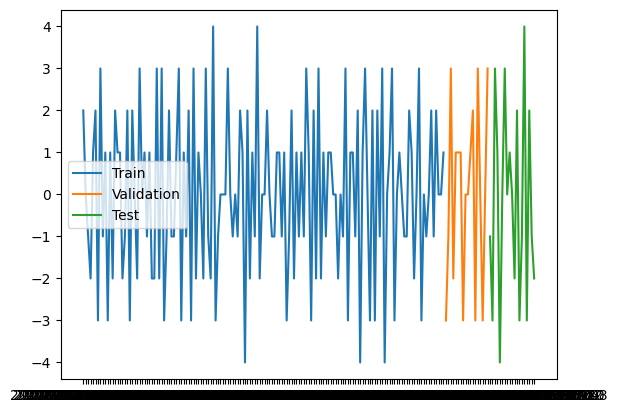

In [108]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

print(X_test)

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [133]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

model = Sequential([layers.Input((20, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.0005),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 65ms/step - loss: 3.5908 - mean_absolute_error: 1.5638 - val_loss: 4.1326 - val_mean_absolute_error: 1.6614
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 3.5209 - mean_absolute_error: 1.5523 - val_loss: 4.0610 - val_mean_absolute_error: 1.6567
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 3.4583 - mean_absolute_error: 1.5421 - val_loss: 3.9883 - val_mean_absolute_error: 1.6509
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 3.3946 - mean_absolute_error: 1.5332 - val_loss: 3.9106 - val_mean_absolute_error: 1.6450
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 3.3208 - mean_absolute_error: 1.5202 - val_loss: 3.8231 - val_mean_absolute_error: 1.6372
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 3.2498 - mean_absolute_error: 1.5095 - val_loss: 3.7202 - val_mean_absolute_error: 1.6276
Epoch 7/100
5/5 [================

5/5 [==============================] - 0s 2ms/step


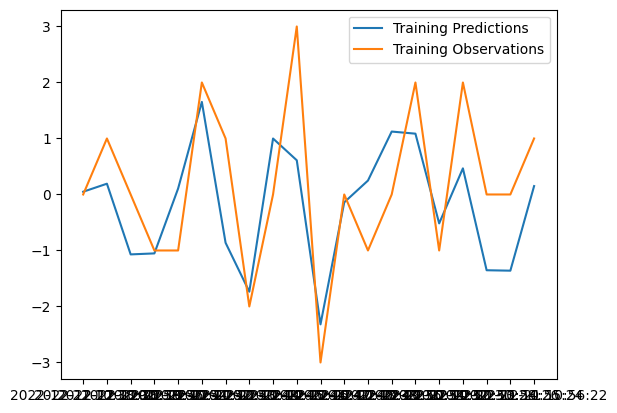

In [134]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train[-20:], train_predictions[-20:])
plt.plot(dates_train[-20:], y_train[-20:])
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 15ms/step


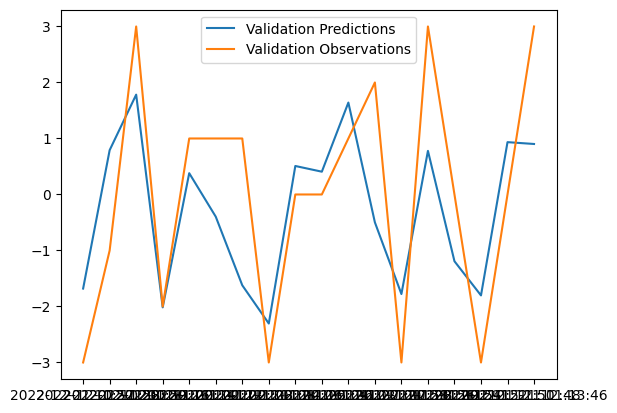

In [135]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val[-20:], val_predictions[-20:])
plt.plot(dates_val[-20:], y_val[-20:])
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 15ms/step
误差范围：1.684482216835022

胜 | 实际值：-1.0 | 预测值（含误差范围）：-0.7703529596328735

负 | 实际值：-3.0 | 预测值（含误差范围）：0.3923804759979248

胜 | 实际值：3.0 | 预测值（含误差范围）：3.7571460008621216

胜 | 实际值：1.0 | 预测值（含误差范围）：0.2021338939666748

负 | 实际值：-4.0 | 预测值（含误差范围）：0.49681365489959717

负 | 实际值：0.0 | 预测值（含误差范围）：2.978928327560425

胜 | 实际值：3.0 | 预测值（含误差范围）：3.0658971071243286

胜 | 实际值：0.0 | 预测值（含误差范围）：-0.2114471197128296

负 | 实际值：1.0 | 预测值（含误差范围）：-0.004729509353637695

胜 | 实际值：0.0 | 预测值（含误差范围）：-0.7055190801620483

负 | 实际值：-2.0 | 预测值（含误差范围）：0.20814120769500732

胜 | 实际值：2.0 | 预测值（含误差范围）：1.8465249687433243

负 | 实际值：-3.0 | 预测值（含误差范围）：0.046886444091796875

负 | 实际值：-1.0 | 预测值（含误差范围）：2.2833167910575867

胜 | 实际值：4.0 | 预测值（含误差范围）：3.499696373939514

负 | 实际值：-3.0 | 预测值（含误差范围）：-0.34808433055877686

胜 | 实际值：2.0 | 预测值（含误差范围）：2.2179994583129883

胜 | 实际值：-1.0 | 预测值（含误差范围）：-0.3660062551498413

负 | 实际值：-2.0 | 预测值（含误差范围）：1.424675852060318


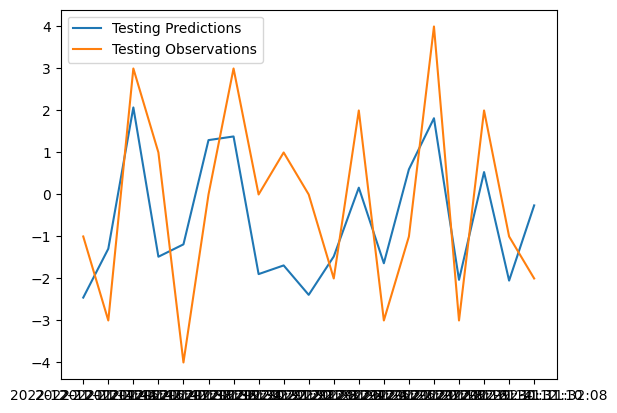

In [137]:
test_predictions = model.predict(X_test).flatten()
import keras.metrics as keras_metrics
mae_ = float(keras_metrics.mean_absolute_error(y_test, test_predictions))
print(f'误差范围：{mae_}')
y_ = y_test.tolist()
test_predictions_ = test_predictions.tolist()
for i in range(len(y_)):
    print()
    if abs(y_[i] - (test_predictions_[i]+mae_)) <= 1:
        print(f'胜 | 实际值：{y_[i]} | 预测值（含误差范围）：{test_predictions_[i]+mae_}')
    else:
        print(f'负 | 实际值：{y_[i]} | 预测值（含误差范围）：{test_predictions_[i]+mae_}')
    
plt.plot(dates_test[-20:], test_predictions[-20:])
plt.plot(dates_test[-20:], y_test[-20:])
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
plt.plot(dates_train[-40:], train_predictions[-40:])
plt.plot(dates_train[-40:], y_train[-40:])
plt.plot(dates_val[-40:], val_predictions[-40:])
plt.plot(dates_val[-40:], y_val[-40:])
plt.plot(dates_test[-40:], test_predictions[-40:])
plt.plot(dates_test[-40:], y_test[-40:])
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])